**Via ce projet nous avons cherchés à élaguer au maximum le réseaux de neurones VGG afin de comprendre à quel point nous pouvions le compresser. Ce notebook a été dévellopé via google colab, d'où des échanges upload/download que vous pourrez voir.**

# Fonctions de traitement

## Création des datasets.

In [ ]:
#!/usr/bin/env python
# coding: utf-8
 
# This script generates the MINICIFAR dataset from CIFAR10
# The following parameters can be changed : 
# n_classes (between 2 and 10) 
# Reduction factor R (which will result in 10000 /  R examples per class for the train set, and 1000 / R per class for test)
# --
 
 
n_classes_minicifar = 4
train_size = 0.8
R = 5
 
 
# Download the entire CIFAR10 dataset
 
from torchvision.datasets import CIFAR10
import numpy as np 
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler
 
 
import torchvision.transforms as transforms
 
## Normalization is different when training from scratch and when training using an imagenet pretrained backbone
 
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 
normalize_forimagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
 
# Data augmentation is needed in order to train from scratch
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])
 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])
 
## No data augmentation when using Transfer Learning 
## however resize to Imagenet input dimensions is recommended for Transfer learning
transform_train_imagenet = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize_forimagenet,
])
 
transform_test_imagenet = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize_forimagenet,
])
 
 
### The data from CIFAR10 will be downloaded in the following dataset
rootdir = './data/cifar10'
 
c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)


 
c10train_imagenet = CIFAR10(rootdir,train=True,download=True,transform=transform_train_imagenet)
c10test_imagenet = CIFAR10(rootdir,train=False,download=True,transform=transform_test_imagenet)
 
# Generating Mini-CIFAR
# 
# CIFAR10 is sufficiently large so that training a model up to the state of the art performance will take approximately 3 hours on the 1060 GPU available on your machine. 
# As a result, we will create a "MiniCifar" dataset, based on CIFAR10, with less classes and exemples. 
 
def train_validation_split(train_size, num_train_examples):
    # obtain training indices that will be used for validation
    indices = list(range(num_train_examples))
    np.random.shuffle(indices)
    idx_split = int(np.floor(train_size * num_train_examples))
    train_index, valid_index = indices[:idx_split], indices[idx_split:]
 
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)
 
    return train_sampler,valid_sampler
 
def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):
 
    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 
 
    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)
 
 
    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    
    return Subset(dataset,indices=all_indices)
    
 
 
### These dataloader are ready to be used to train for scratch 
minicifar_train= generate_subset(dataset=c10train,n_classes=n_classes_minicifar,reducefactor=R,n_ex_class_init=5000)
num_train_examples=len(minicifar_train)
train_sampler,valid_sampler=train_validation_split(train_size, num_train_examples)
minicifar_test = generate_subset(dataset=c10test,n_classes=n_classes_minicifar,reducefactor=1,n_ex_class_init=1000) 
 
 
### These dataloader are ready to be used to train using Transfer Learning 
### from a backbone pretrained on ImageNet
minicifar_train_im= generate_subset(dataset=c10train_imagenet,n_classes=n_classes_minicifar,reducefactor=R,n_ex_class_init=5000)
num_train_examples_im=len(minicifar_train_im)
train_sampler_im,valid_sampler_im=train_validation_split(train_size, num_train_examples_im)
minicifar_test_im= generate_subset(dataset=c10test_imagenet,n_classes=n_classes_minicifar,reducefactor=1,n_ex_class_init=1000)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.utils.data.dataloader import DataLoader

c10train_sampler,c10valid_sampler=train_validation_split(0.8, len(c10train))

c10trainloader = DataLoader(c10train,batch_size=32,sampler=c10train_sampler)
c10validloader = DataLoader(c10train,batch_size=32,sampler=c10valid_sampler)
c10testloader = DataLoader(c10test,batch_size=32)
#from minicifar import minicifar_train,minicifar_test,train_sampler,valid_sampler


trainloader = DataLoader(minicifar_train,batch_size=32,sampler=train_sampler)
validloader = DataLoader(minicifar_train,batch_size=32,sampler=valid_sampler)
testloader = DataLoader(minicifar_test,batch_size=32)

## Architectures de VGG

In [ ]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Fonctions de visualisation

In [ ]:
from torch import nn, optim
import torchvision
import torch.optim as optim
from google.colab import files


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(test_loss,training_loss,n_epochs) : 
  plt.figure()
  test_ax=np.arange(0,n_epochs,n_epochs/len(test_loss))
  train_ax=np.arange(0,n_epochs,n_epochs/len(training_loss))

  plt.plot(test_ax,test_loss,"r")
  plt.plot(train_ax,training_loss)
  plt.xlabel('epoch')
  plt.ylabel('loss') 


In [ ]:
def plot_log_loss(test_loss,training_loss,n_epochs) : 
  plt.figure()
  test_ax=np.arange(0,n_epochs,n_epochs/len(test_loss))
  train_ax=np.arange(0,n_epochs,n_epochs/len(training_loss))

  plt.plot(test_ax,np.log(np.array(test_loss)),"r")
  plt.plot(train_ax,np.log(np.array(training_loss)))
  plt.xlabel('epoch')
  plt.ylabel('log(loss)')   


In [ ]:

def print_accuracy(net,testloader ) : 
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():  # torch.no_grad for TESTING
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    

    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    classes = ('1', '2', '3', '4')
    for i in range(4):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
def eval_accuracy(net,testloader ) : 
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():  # torch.no_grad for TESTING
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()


    return 100*correct/total

    

In [ ]:
def plot_accuracy(accuracy,n_epochs):
    plt.figure()
    test_ax=np.arange(0,n_epochs,n_epochs/len(accuracy))
    plt.plot(test_ax,accuracy,"r")
    plt.ylabel('acurracy %')
    plt.xlabel('epoch') 



## Pruning

### Fonctions de Pruning

In [ ]:


def trainingwithPrunning(trainloader,validloader,testloader,n_epochs,criterion,optimizer,mymodel,valid_losses=[],training_losses=[],test_accuracys=[],scheduler=True) : 
  
  

  
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
      train_loss,valid_loss=0,0
      
      print("epoch ",epoch)

      running_loss = 0.0
      mymodel.model.train()

      for data,label in trainloader:
          
          if data_int :
              data=data.half()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize

          outputs = mymodel.forward(data.to(device))

          loss = criterion(outputs, label.to(device))

          loss.backward()

          optimizer.step()
 
          # print statistics
          train_loss += loss.item()*data.size(0)
          
      mymodel.model.eval()
      for data,label in validloader:
          if data_int :
              data=data.half()
          
          outputs = mymodel.forward(data.to(device))

          loss = criterion(outputs, label.to(device))

          # print statistics
          valid_loss += loss.item()*data.size(0)

      train_loss /= len(trainloader.sampler)
      valid_loss /= len(validloader.sampler)
      training_losses.append(train_loss)
      if scheduler :
        lr_scheduler.step(valid_loss)

      #lr_scheduler.step(running_loss/i)        
      valid_losses.append(valid_loss)
      

      #if running_loss/i==min(test_loss) :
      print("saving weights.... ")

      torch.save(mymodel.model.state_dict(), 'checkpoint_bin.pt')
      
      test_accuracy=eval_accuracy(mymodel.model,testloader )

      print(test_accuracy," % , ",valid_losses[-1]," , ",training_losses[-1])
      test_accuracys.append(test_accuracy)

  #print(training_losses)
  print('Finished Training')
  return valid_losses,training_losses, test_accuracys

In [ ]:
def get_number_param_pruned(model):
  total_conv=0
  total_fc=0

  for name, module in model.named_modules():
    

    if isinstance(module, torch.nn.Conv2d):

      l=list(module.named_buffers())

      total_conv+=torch.sum(l[0][1].type(torch.DoubleTensor)).item()
      #print(len(l[0][1]))
       
    elif isinstance(module, torch.nn.Linear):

      l=list(module.named_buffers())
      #print(torch.sum(l[0][1]).item())

      total_fc+=torch.sum(l[0][1]).item()

  pp=0
  for p in list(model.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  #print("params_initiaux : ",pp)
  #print("nouveaux conv : ",total_conv)
  #print("nouveaux fc : ",total_fc)
  return total_conv,total_fc

In [ ]:
import torch.nn as nn
import numpy
from torch.autograd import Variable
import torch.nn.utils.prune as prune


class my_network_with_trous():## Classe permettant de pruner un réseaux de neurones facilement
    def __init__(self, model):


        self.model = model # this contains the model that will be trained and quantified



    def forward(self,x):

        ### This function is used so that the model can be used while training
        out = self.model(x)
        return out

    def prune_all_layers(self,ratio):
        #self.save_params()
        #for index in range(self.num_of_params):
        #    prune.random_unstructured(self.target_modules[index], name="weight", amount=ratio)
        print("Pruning....")
        
        for name, module in self.model.named_modules():
            
              if isinstance(module, torch.nn.Conv2d):
                  prune.ln_structured(module, name='weight', n=2,dim=ratio["dim"],amount=ratio["conv"])
                  #prune.remove(module,"weight")
    
              elif isinstance(module, torch.nn.Linear):
                  prune.ln_structured(module, name='weight',n=2,dim=1, amount=ratio["fc"])
                  #prune.remove(module,"weight")

        #print(dict(self.model.named_buffers()).keys())  # to verify that all masks exist

    def prune_spef_layer(self,name_layer,ratio,dim):
        for name, module in self.model.named_modules():
              
              #print(list(module.named_buffers()))
              if str(name)==name_layer :

                  print(name)
                  prune.ln_structured(module, name='weight', n=2,dim=dim,amount=ratio)

                  #print(list(module.named_buffers()))
    
              #elif isinstance(module, torch.nn.Linear):
                  #print(list(module.named_buffers()))
              if str(name_layer)=="a" and isinstance(module, torch.nn.Conv2d):
                  print(name)
              elif str(name_layer)=="a" and isinstance(module, torch.nn.Linear):
                  print(name)
      
                  


## La fonction profile

**Cette fonction nous a été donnée afin de mesurer la compression de notre réseau.**

In [ ]:
import os
import torch
import torch.nn as nn


def count_conv2d(m, x, y):
    x = x[0] # remove tuple
    fin = m.in_channels
    fout = m.out_channels
    sh, sw = m.kernel_size
    total_params=0
    for p in m.parameters():
        total_params += torch.Tensor([p.numel()]) / 2  # Division Free quantification

    # ops per output element
    kernel_mul = sh * sw * fin
    kernel_add = sh * sw * fin - 1
    bias_ops = 1 if m.bias is not None else 0
    kernel_mul = kernel_mul/2 # FP16
    ops = kernel_mul + kernel_add + bias_ops
    #print(len(y))
    # total ops
    taux=int(m.total_params.item())/total_params
    print(taux)
    num_out_elements = y.numel()*taux
    total_ops = num_out_elements * ops

    print("Conv2d: S_c={}, F_in={}, F_out={}, P={}, params={}, operations={}".format(sh,fin,fout,x.size()[2:].numel(),int(m.total_params.item()),int(total_ops)))
    # incase same conv is used multiple times
    m.total_ops += torch.Tensor([int(total_ops)])

def count_linear(m, x, y):
    # per output element
    print(m.in_features)
    total_mul = m.in_features/2
    total_add = m.in_features - 1

    total_params=0
    for p in m.parameters():
        total_params += torch.Tensor([p.numel()]) #/ 2  # Division Free quantification

    taux=int(m.total_params.item())/total_params


    num_elements = y.numel()
    total_ops = (total_mul + total_add) * num_elements*taux
    print("Linear: F_in={}, F_out={}, params={}, operations={}".format(m.in_features,m.out_features,int(m.total_params.item()),int(total_ops)))
    m.total_ops += torch.Tensor([int(total_ops)])


def count_bn2d(m, x, y):
    x = x[0] # remove tuple

    nelements = x.numel()
    total_sub = 2*nelements
    total_div = nelements
    total_ops = total_sub + total_div

    m.total_ops += torch.Tensor([int(total_ops)])
    print("Batch norm: F_in={} P={}, params={}, operations={}".format(x.size(1),x.size()[2:].numel(),int(m.total_params.item()),int(total_ops)))


def count_relu(m, x, y):
    x = x[0]

    nelements = x.numel()
    total_ops = nelements

    m.total_ops += torch.Tensor([int(total_ops)])
    print("ReLU: F_in={} P={}, params={}, operations={}".format(x.size(1),x.size()[2:].numel(),0,int(total_ops)))



def count_avgpool(m, x, y):
    x = x[0]
    total_add = torch.prod(torch.Tensor([m.kernel_size])) - 1
    total_div = 1
    kernel_ops = total_add + total_div
    num_elements = y.numel()
    total_ops = kernel_ops * num_elements

    m.total_ops += torch.Tensor([int(total_ops)])
    print("AvgPool: S={}, F_in={}, P={}, params={}, operations={}".format(m.kernel_size,x.size(1),x.size()[2:].numel(),0,int(total_ops)))

def count_sequential(m, x, y):
    print ("Sequential: No additional parameters  / op")

# custom ops could be used to pass variable customized ratios for quantization
def profile(model, input_size, custom_ops = {}):

    model.eval()

    def add_hooks(m):
        if len(list(m.children())) > 0: return
        m.register_buffer('total_ops', torch.zeros(1))
        m.register_buffer('total_params', torch.zeros(1))

        for p in m.parameters():
            if isinstance(m, torch.nn.Conv2d):
                m.total_params += (torch.count_nonzero(torch.cat([param.view(-1) for param in m.parameters()]).detach()))/ 2 # Division Free quantification
            elif isinstance(m, torch.nn.Linear):
                m.total_params += (torch.count_nonzero(torch.cat([param.view(-1) for param in m.parameters()]).detach()))/ 2 # Division Free quantification
            else:
                m.total_params += torch.Tensor([p.numel()]) / 2 # Division Free quantification

        if isinstance(m, nn.Conv2d):
            m.register_forward_hook(count_conv2d)
        elif isinstance(m, nn.BatchNorm2d):
            m.register_forward_hook(count_bn2d)
        elif isinstance(m, nn.ReLU):
            m.register_forward_hook(count_relu)
        elif isinstance(m, (nn.AvgPool2d)):
            m.register_forward_hook(count_avgpool)
        elif isinstance(m, nn.Linear):
            m.register_forward_hook(count_linear)
        elif isinstance(m, nn.Sequential):
            m.register_forward_hook(count_sequential)
        else:
            print("Not implemented for ", m)

    model.apply(add_hooks)

    x = torch.zeros(input_size)
    if data_int :
        x=x.half()
    model(x)

    total_ops = 0
    total_params = 0
    for m in model.modules():
        if len(list(m.children())) > 0: continue
        total_ops += m.total_ops
        total_params += m.total_params
    return total_ops, total_params

def mesure_operation(model,ref="VGG16"):
    # Resnet18 - Reference for CIFAR 10
    
     # Resnet18 - Reference for CIFAR 10

    ref_params = 5586981
    ref_flops  = 834362880

    if ref=="mobileNet" :
      ref_params = 1118885.0
      ref_flops = 9299442688.0

    elif ref=="VGG16" : 
      ref_params = 14724042.0
      ref_flops  = 940703744.0

    #Flops: 470908896.0, Params: 14724041.0
    model = model.to("cpu")
    # WideResnet-28-10 - Reference for CIFAR 100 
    # ref_params = 36500000
    # ref_flops  = 10490000000

    #model = resnet.ResNet18()
    #print(model)
    flops, params = profile(model, (1,3,32,32))
    flops, params = flops.item(), params.item()

    score_flops = flops / ref_flops
    score_params = params / ref_params
    score = score_flops + score_params
    print("Flops: {}, Params: {}".format(flops,params))
    print("Score flops: {} Score Params: {}".format(score_flops,score_params))
    print("Final score: {}".format(score))
    model = model.to(device)




# Etude sur un réseaux quantifié

**Ces données ont été obtenus via une étude précédente. Nous avons comparé des réseaux 32 bits et 34 bits avec différents taux d'élagages**

Text(0, 0.5, 'Accuracy')

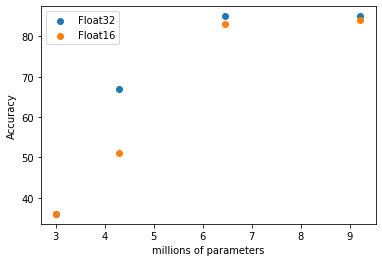

In [ ]:
a= [9.217728,6.445503,4.297002,3.005190]
b=[85,85,67,36]
c=[9.217728,6.445503,4.297002,3.005190]
d=[84,83,51,36]

fig=plt.scatter(a,b)

plt.scatter(c,d)
plt.legend(["Float32","Float16"])
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")



# Minicifar

## Première expérience d'élagage sur minicifar

In [ ]:
data_int=False### cette constante permet de définir si oui ou non on fait de la quantification sur nos poids : 
#True : 32 bits ou False : 64 bits pour chaque poids

In [ ]:
net = VGG('VGG16')
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:

net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()
lr=0.001
n_epochs=[22,30,20]
pruning_coefs=[{"fc":0.3 , "conv":0.3,"dim":0},{"fc":0.4 , "conv":0.3,"dim":2}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
print(get_number_param_pruned(mymodel.model))

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

mymodel.prune_all_layers(pruning_coefs[1])
get_number_param_pruned(mymodel.model)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

epoch  0
saving weights.... 
65.65  % ,  0.9177489304542541  ,  1.0682913821935653
epoch  1
saving weights.... 
65.125  % ,  0.8306737053394317  ,  0.8712142884731293
Finished Training
Pruning....
(14710464.0, 2048.0)
epoch  0
saving weights.... 
68.55  % ,  0.9009149146080017  ,  0.7548020806908607
epoch  1
saving weights.... 
72.825  % ,  0.7062627482414245  ,  0.708474158346653
Finished Training
Pruning....
epoch  0
saving weights.... 
70.45  % ,  0.9119302475452423  ,  0.8206265556812287
epoch  1
saving weights.... 
69.8  % ,  0.8463314270973206  ,  0.7093483358621597
Finished Training


In [ ]:
mymodel.prune_spef_layer("a",5,5)
# Affichage des layers convolutionnels et du classifier

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.24
features.27
features.30
features.34
features.37
features.40
classifier


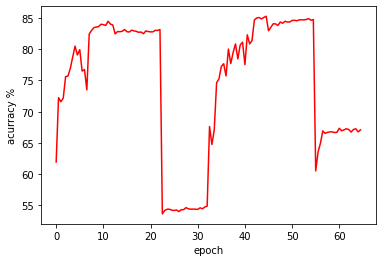

In [ ]:
# Affichage de l'accuracy au fur et à mesure des epochs. 
plot_accuracy(test_accuracy,sum(n_epochs))

**On peut voir les 2 élagages, aux moments de forte décroissance de l'accuracy. On peut aussi voir qu'après le 2ème élagage le réseau perde beaucoup d'accuracy qu'il ne regagnera probablement pas.**

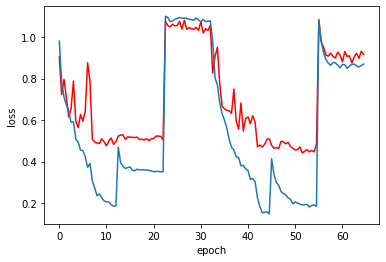

In [ ]:
plot_loss(valid_loss,training_loss,sum(n_epochs))
# On observe des comportements 

**On observe aussi ici les différents élagages**

In [ ]:
print("top-accuracy : ",max(test_accuracy))
      

top-accuracy :  85.275


In [ ]:
get_number_param_pruned(mymodel.model)

params_initiaux :  9228036
nouveaux conv :  3072576.0
nouveaux fc :  612.0


## Pruning specific layers

**Ici nous mènerons une étude plus fine en élagagant chaque layers à différents taux afin d'observer l'impact sur l'efficacité du réseaux. Pour cela nous entrainons un model que nous élaguons ( 30% des poids des étages convolutionnels sur la dimension 0 -input features- et 70% des poids des couches full connectés). Puis nous le reentrainons afin de remonter notre effiacité, puis nous le reélaguons à différents taux sur différents layers sur la dimension 2 - output features-.**

In [ ]:


net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.001
n_epochs=[25,20,16]
pruning_coefs=[{"fc":0.7 , "conv":0.3,"dim":0}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)

print(paramconv1,paramfc1)

valid_loss1,training_loss1,test_accuracy1 = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

#torch.save(mymodel.model.state_dict(), 'checkpoint.pt')
state = {
            'net': mymodel.model.state_dict(),
            'scheduler': lr_scheduler,
            'optimizer': optimizer,
    }
torch.save(state, 'checkpoint.pt')

print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy1))
print("_____________________________________")

ratio_conv=[0.3,0.6]
#list_modules=["features.0","features.4","features.8","features.11","features.15","features.18","features.22","features.25"]    VGG11

recap_dic={}
list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]



for ratios in ratio_conv :  
  print("________________________________________________________")
  print("setting ratio to ",ratios)
  for module in list_modules:
    valid_loss,training_loss,test_accuracy=[],[],[]

    loaded_cpt = torch.load('checkpoint.pt')

    mymodel.model.load_state_dict(loaded_cpt["net"])

    lr_scheduler=loaded_cpt['scheduler']

    optimizer=loaded_cpt['optimizer']


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("changing module : ", module)
    
    mymodel.prune_spef_layer(module,ratios,2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)

    valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

    recap_dic[str(ratios)+" "+module]={
        "test_acc" :test_accuracy ,
        "valid_loss": valid_loss,
        "training_loss": training_loss ,
        "nbr_param":[paramfc2,paramconv2] ,
    }



0.3 features.0
77.775
[616.0, 10286442.0]

0.3 features.3
81.2
[616.0, 10278207.0]

0.3 features.7
81.525
[616.0, 10269567.0]

0.3 features.10
81.575
[616.0, 10252287.0]

0.3 features.14
81.15
[616.0, 10218111.0]

0.3 features.17
82.1
[616.0, 10149375.0]

0.3 features.20
83.325
[616.0, 10149375.0]

0.3 features.24
82.525
[616.0, 10011903.0]

0.3 features.27
82.75
[616.0, 9736959.0]

0.3 features.30
83.75
[616.0, 9736959.0]

0.3 features.34
83.35
[616.0, 9736959.0]

0.3 features.37
83.45
[616.0, 9736959.0]

0.3 features.40
83.925
[616.0, 9736959.0]

0.6 features.0
62.7
[616.0, 10286037.0]

0.6 features.3
74.4
[616.0, 10269567.0]

0.6 features.7
73.1
[616.0, 10252287.0]

0.6 features.10
77.125
[616.0, 10217727.0]

0.6 features.14
70.2
[616.0, 10149375.0]

0.6 features.17
81.0
[616.0, 10011903.0]

0.6 features.20
78.775
[616.0, 10011903.0]

0.6 features.24
80.95
[616.0, 9736959.0]

0.6 features.27
82.4
[616.0, 9187071.0]

0.6 features.30
83.1
[616.0, 9187071.0]

0.6 features.34
83.65
[616

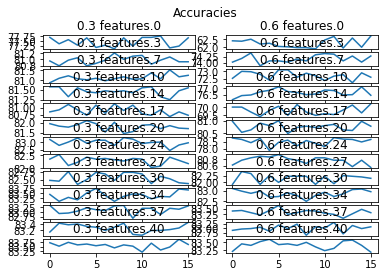

In [ ]:
fig, axs = plt.subplots(13,2)
fig.suptitle('Accuracies')



for key, value in recap_dic.items() :
  if key[:3]==str(0.3):
    y=0
  else :
    y=1
  test_ax=np.arange(0,n_epochs[-1],n_epochs[-1]/len(value["test_acc"]))

  axs[list_modules.index(key[4:]), y].plot(test_ax, value["test_acc"])
  axs[list_modules.index(key[4:]), y].set_title(key)

  print(key)
  print(max(value["test_acc"]))
  print(value["nbr_param"])
  print()
#7,1



In [ ]:

figure=plt.figure(figsize=(10,10))

for key, value in recap_dic.items() :
  #if key[:3]==str(0.3):

  print(key," : ",max(value["test_acc"])," ---- ",sum(value["nbr_param"]))
  plt.scatter(sum(value["nbr_param"]),max(value["test_acc"]))

plt.legend(recap_dic.keys())
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")

**L'image n'est plus disponible, mais nous retenons de cette expérience qu'il est possible de pruner à haut taux les derniers layers, mais qu'il est plus compliqué de pruner les layers de bas niveau**

## Application à Cifar 10

In [ ]:


net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.1
n_epochs=[100,20,16]
pruning_coefs=[{"fc":0.7 , "conv":0.3,"dim":0}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)

print(paramconv1,paramfc1)
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)

valid_loss1,training_loss1,test_accuracy1 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 



print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy1))
print("_____________________________________")




pruned_liste=[[0.6,"features.40"],[0.6,"features.34"],[0.3,"features.30"],[0.6,"features.37"]]



for element in pruned_liste :

    mymodel.prune_spef_layer(element[1],element[0],2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss2,training_loss2,test_accuracy2 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

    
print(max(test_accuracy2))
print(paramconv2,paramfc2)



In [ ]:

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss2,training_loss2,test_accuracy2 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

## Test avec 3 prunage

**Ici nous allons travailler sur cifar 10. Nous allons pruner divers étages de VGG à différents taux. En raison du temps de calculs nécessaires à cela, des sauvegardes de résultats sont effectuées.**


### 1er entrainement

Nous entrainons un premier modèle :
- premier entrainement (from scratch) de 100 epoch avec lr = 0.1 (, avec weight  decay, momentum et lr scheduler)

- Pruning de touts les layers convolutionnels à 30% sur la dim 0 ( input features) et 90% sur les full connected
- Fine tuning : reentrainement sur 20 epochs, lr = 0.01(, avec weight  decay, momentum)
- Fine tuning : reentrainement sur 10 epochs, lr = 0.001(, avec weight  decay, momentum)

- Pruning de touts les layers à 30% sur la dim 1 ( kernel)
- Fine tuning : reentrainement sur 20 epochs, lr = 0.01(, avec weight  decay, momentum)
- Fine tuning : reentrainement sur 10 epochs, lr = 0.001(, avec weight  decay, momentum)


Après expériences, nous avons réalisés que réaliser 2 réentrainement avec un lr qui se réduisait, permettaient de grandement améliorer notre fine-tuning.

In [ ]:

data_int=False
net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.1
n_epochs=[100,20,10,20,10,20,10]
pruning_coefs=[{"fc":0.9 , "conv":0.3,"dim":0},{"fc":0 , "conv":0.3,"dim":1}]

#premier entrainement
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.1, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[0],criterion,optimizer,mymodel) 


#1er pruning
mymodel.prune_all_layers(pruning_coefs[0])
paramconv0,paramfc0=get_number_param_pruned(mymodel.model)
print(paramconv0,paramfc0)

#2ème entrainement
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False )

#2ème entrainement bis
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 

#2ème pruning
mymodel.prune_all_layers(pruning_coefs[1])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)
print(paramconv1,paramfc1)


#3ème entrainement 
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[3],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 

#3ème entrainement bis
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[4],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 








#torch.save(mymodel.model.state_dict(), 'checkpoint.pt')
state = {
            'net': mymodel.model.state_dict(),
            'scheduler': lr_scheduler,
            'optimizer': optimizer,
    }
torch.save(state, 'checkpoint.pt')






print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy))
print("_____________________________________")











epoch  0
saving weights.... 
11.67  % ,  2.3020303283691406  ,  2.417413781929016
epoch  1
saving weights.... 
20.72  % ,  2.066643391418457  ,  2.1081053373336793
epoch  2
saving weights.... 
34.58  % ,  1.73147279586792  ,  1.7918777463912965
epoch  3
saving weights.... 
32.19  % ,  2.4348307025909426  ,  1.5905733932495116
epoch  4
saving weights.... 
32.84  % ,  2.684371448135376  ,  1.443699486351013
epoch  5
saving weights.... 
54.11  % ,  1.3757770265579223  ,  1.2983197905540467
epoch  6
saving weights.... 
54.47  % ,  1.540200781059265  ,  1.184232015800476
epoch  7
saving weights.... 
58.96  % ,  1.3641583070755006  ,  1.1295040771007538
epoch  8
saving weights.... 
54.38  % ,  1.3603452348709106  ,  1.076919110441208
epoch  9
saving weights.... 
60.29  % ,  1.1539476640701294  ,  1.056083007645607
epoch  10
saving weights.... 
67.85  % ,  0.9873358587265014  ,  1.0466141822338104
epoch  11
saving weights.... 
53.51  % ,  1.5343587635040283  ,  1.03401013982296
epoch  12
savi

NameError: ignored

In [ ]:
#from google.colab import drive
from google.colab import files
#drive.mount('/content/drive', force_remount=True)


#files.upload()

files.download('checkpoint.pt')# Permet de récupérer notre avancement

### Prune sur les features

Ici on prune un étage spécifique à un taux spécifique, puis on réentraine afin de remonter notre accuracy.

Le pruning se fait sur la dim 2
Le réentrainement se fait sur 20 epochs, avec lr = 0.01, puis sur 10 epochs avec lr =0.001


In [ ]:
from google.colab import files
import numpy as np
import io
data_int=False
def prune_fine_tune(ind_module,ratio_conv=[0.3,0.6]):
  try: 
    loaded_cpt = torch.load('checkpoint.pt')

  except :


    print("Chargez les poids")
    files.upload()
    loaded_cpt = torch.load('checkpoint.pt')

  
  net = VGG('VGG16')
  
  if data_int :
    net.half()
  mymodel = my_network_with_trous(net)
  mymodel.model = mymodel.model.to(device)
  criterion = nn.CrossEntropyLoss()


  
  recap_dic={}
  dic_save={}
  list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]
  module=list_modules[ind_module]
  for ratios in ratio_conv :  
    print("________________________________________________________")
    print("setting ratio to ",ratios)
    
    valid_loss,training_loss,test_accuracy=[],[],[]
    

    mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})# nécessaire car sinon le réseau bug, ici on élague 0 paramètres

    mymodel.model.load_state_dict(loaded_cpt["net"])
    #mymodel.model.load_state_dict(io.BytesIO(loaded_cpt["net"]))

    #lr_scheduler=loaded_cpt['scheduler']

    #optimizer=loaded_cpt['optimizer']


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("changing module : ", module)
    
    mymodel.prune_spef_layer(module,ratios,2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)
    # entrainement a

    optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
    valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel,scheduler=False ) 

    #entrainement b

    optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
    valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 


    recap_dic[str(ratios)+" "+module]={
        "test_acc" :test_accuracy ,
        "valid_loss": valid_loss,
        "training_loss": training_loss ,
        "nbr_param":[paramfc2,paramconv2] 
    }
    
    dic_save[str(ratios)+" "+module]={
        "test_acc" :max(test_accuracy) ,
        "nbr_param":[paramfc2,paramconv2] 
    }
  
  try: 
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')
    
    current_feature=current_feature.tolist()

    for key, value in current_feature.items() :
      dic_save[key]=value


  except :
    print("chargez ",i,".npy, si inexistant annuler")
    files.upload()
    try :

      current_feature=np.load(i+'.npy', allow_pickle='TRUE')
      current_feature=current_feature.tolist()

      for key, value in current_feature.items() :
        dic_save[key]=value
      

    except :
      np.save(module+'.npy', dic_save)
      files.download(module+'.npy')


  return recap_dic



  

### Prune sur "features.0"


In [ ]:
prune_fine_tune(0,[0.8,0.875])

### Prune sur "features.3"

In [ ]:
prune_fine_tune(1,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.3
features.3
7188156.0 510.0
epoch  0
saving weights.... 
83.32  % ,  0.4187791236877441  ,  0.4079273605465889
epoch  1
saving weights.... 
83.88  % ,  0.4018106766104698  ,  0.3540658381551504
epoch  2
saving weights.... 
82.56  % ,  0.4652509907484055  ,  0.33332614375948905
epoch  3
saving weights.... 
85.09  % ,  0.40118082023859025  ,  0.32534253038167954
epoch  4
saving weights.... 
84.33  % ,  0.46513295035362245  ,  0.32141239524483683
epoch  5
saving weights.... 
84.74  % ,  0.4175166788101196  ,  0.3130440088123083
epoch  6
saving weights.... 
83.42  % ,  0.4576169460296631  ,  0.31074335777163503
epoch  7
saving weights.... 
82.12  % ,  0.540731411576271  ,  0.30931447079479696
epoch  8
saving weights.... 
86.11  % ,  0.4185573099374771  ,  0.3087220321804285
epoch  9
saving weights.... 
86.25  % ,  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.3': {'nbr_param': [510.0, 7188156.0],
  'test_acc': [83.98,
   85.75,
   85.77,
   85.73,
   86.59,
   84.29,
   85.47,
   86.27,
   85.07,
   86.61,
   85.96,
   85.99,
   85.72,
   86.05,
   84.93,
   86.52,
   85.63,
   85.14,
   85.41,
   86.03,
   90.2,
   90.57,
   90.81,
   90.9,
   91.01,
   90.97,
   90.62,
   90.68,
   90.92,
   90.9,
   83.63,
   84.01,
   82.57,
   85.63,
   81.29,
   85.27,
   84.91,
   85.81,
   83.41,
   81.7,
   85.41,
   86.15,
   83.99,
   83.5,
   86.16,
   85.99,
   86.5,
   84.18,
   84.8,
   85.8,
   85.96,
   85.72,
   85.13,
   85.66,
   89.83,
   90.09,
   90.38,
   90.38,
   90.43,
   90.56,
   90.61,
   90.53,
   90.64,
   90.58,
   83.77,
   82.95,
   85.76,
   84.82,
   83.32,
   85.02,
   85.55,
   86.23,
   85.49,
   85.14,
   84.13,
   84.93,
   84.85,
   85.88,
   85.66,
   85.14,
   85.73,
   85.74,
   84.58,
   85.94,
   89.86,
   90.43,
   90.48,
   90.55,
   90.41,
   90.74,
   90.74,
   90.41,
   90.3,
   90.49,
   8

### Prune sur "features.7"

In [ ]:
prune_fine_tune(2,[0.8,0.875])

### Prune sur "features.10"


In [ ]:
prune_fine_tune(3,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.10
features.10
7169931.0 510.0
epoch  0
saving weights.... 
84.85  % ,  0.37885906960964205  ,  0.3915827317610383
epoch  1
saving weights.... 
85.14  % ,  0.3813879222869873  ,  0.36015125019550326
epoch  2
saving weights.... 
85.97  % ,  0.36162704025506975  ,  0.3394492732614279
epoch  3
saving weights.... 
86.47  % ,  0.36307315928936007  ,  0.33276546038389204
epoch  4
saving weights.... 
85.85  % ,  0.373699124789238  ,  0.321261684307456
epoch  5
saving weights.... 
84.84  % ,  0.4199017300724983  ,  0.317406006988883
epoch  6
saving weights.... 
84.26  % ,  0.4386263092637062  ,  0.31472248481065035
epoch  7
saving weights.... 
86.4  % ,  0.37494810302257536  ,  0.31368526110053063
epoch  8
saving weights.... 
86.52  % ,  0.38244445865154264  ,  0.30694957921504973
epoch  9
saving weights.... 
86.11  % , 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.10': {'nbr_param': [510.0, 7169931.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

### Prune sur "features.14"


In [ ]:
prune_fine_tune(4,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.14
features.14
7145901.0 510.0
epoch  0
saving weights.... 
82.52  % ,  0.42210225051641465  ,  0.40907566645145416
epoch  1
saving weights.... 
85.01  % ,  0.35383942351341247  ,  0.360950541138649
epoch  2
saving weights.... 
83.73  % ,  0.4297317171573639  ,  0.35040272166132924
epoch  3
saving weights.... 
85.0  % ,  0.4053603218317032  ,  0.3473049049317837
epoch  4
saving weights.... 
84.73  % ,  0.4291050954580307  ,  0.3275092122018337
epoch  5
saving weights.... 
85.54  % ,  0.3971800770521164  ,  0.3349805044710636
epoch  6
saving weights.... 
83.11  % ,  0.4493438600540161  ,  0.31958931329548357
epoch  7
saving weights.... 
86.34  % ,  0.3755212651491165  ,  0.31514615920186045
epoch  8
saving weights.... 
85.08  % ,  0.4161437240600586  ,  0.3107901745721698
epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.14': {'nbr_param': [510.0, 7145901.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55],
  'training_loss': [0.40907566645145416,
   0.360950541138649,
   0.35040272166132924,
   0.3473049049317837,
   0.3275092122018337,
   0.3349805044710636,
   0.31958931329548357,
   0.31514615920186045,
   0.3107901745721698,
   0.3090474818378687,
   0.30886315927356484,
   0.3099342880159616,
   0.31027158932387827,
   0.302051755583286

### Prune sur "features.17"


In [ ]:
prune_fine_tune(5,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.17
features.17
7098108.0 510.0
epoch  0
saving weights.... 
85.68  % ,  0.3673545283079147  ,  0.4165575761258602
epoch  1
saving weights.... 
84.31  % ,  0.391107876932621  ,  0.36688573741316793
epoch  2
saving weights.... 
84.46  % ,  0.424245005774498  ,  0.3547136522620916
epoch  3
saving weights.... 
86.06  % ,  0.38230340807437896  ,  0.3405995216906071
epoch  4
saving weights.... 
83.46  % ,  0.4369804766893387  ,  0.3373549881637096
epoch  5
saving weights.... 
83.73  % ,  0.4667327652692795  ,  0.32738397109508516
epoch  6
saving weights.... 
84.62  % ,  0.42256137087345125  ,  0.32126084246337416
epoch  7
saving weights.... 
87.1  % ,  0.3763585899591446  ,  0.3222502499461174
epoch  8
saving weights.... 
85.3  % ,  0.43210205738544466  ,  0.32008050666749477
epoch  9
saving weights.... 
84.62  % ,  0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.17': {'nbr_param': [510.0, 7098108.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

### Prune sur "features.20"


In [ ]:
prune_fine_tune(6,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.20
features.20
7098108.0 510.0
epoch  0
saving weights.... 
82.38  % ,  0.44386775991916655  ,  0.3860620348814875
epoch  1
saving weights.... 
85.91  % ,  0.3670612971305847  ,  0.3473760468780994
epoch  2
saving weights.... 
83.35  % ,  0.4275624608039856  ,  0.34364650651216505
epoch  3
saving weights.... 
82.6  % ,  0.4840765997886658  ,  0.3364586474478245
epoch  4
saving weights.... 
84.85  % ,  0.3922687263250351  ,  0.32359960429370405
epoch  5
saving weights.... 
84.45  % ,  0.41186701002120973  ,  0.32146553917229176
epoch  6
saving weights.... 
85.95  % ,  0.38272371337413785  ,  0.31804814372062684
epoch  7
saving weights.... 
85.39  % ,  0.41316329424381254  ,  0.31285910589694976
epoch  8
saving weights.... 
86.71  % ,  0.3868884770154953  ,  0.3148858815908432
epoch  9
saving weights.... 
86.42  % 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.20': {'nbr_param': [510.0, 7098108.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

### Prune sur "features.24"


In [ ]:
prune_fine_tune(7,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.24
features.24
7001985.0 510.0
epoch  0
saving weights.... 
83.82  % ,  0.4152320156812668  ,  0.3753677779302001
epoch  1
saving weights.... 
85.64  % ,  0.3291621312737465  ,  0.3462250084847212
epoch  2
saving weights.... 
84.67  % ,  0.42519748874902724  ,  0.33190153065472844
epoch  3
saving weights.... 
85.43  % ,  0.3677966022372246  ,  0.33085808129012584
epoch  4
saving weights.... 
84.26  % ,  0.42426420383453367  ,  0.31621220431029795
epoch  5
saving weights.... 
83.59  % ,  0.45190358481407167  ,  0.31845793751180174
epoch  6
saving weights.... 
86.91  % ,  0.3446594207048416  ,  0.3156200372368097
epoch  7
saving weights.... 
85.1  % ,  0.4067449975728989  ,  0.30667638978362083
epoch  8
saving weights.... 
85.63  % ,  0.41236174714565277  ,  0.3017140057712793


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.24': {'nbr_param': [510.0, 7001985.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99],
  'training_loss': [0.3753677779302001,
   0.3462250084847212,
   0.33190153065472844,
   0.33085808129012584,
   0.31621220431029795,
   0.31845793751180174,
   0.3156200372368097,
   0.30667638978362083,
   0.3017140057712793,
   0.30335422294437886,
   0.29924887719750404,
   0.2995054669216275,
   0.30042183919698,
   0.2942349959120

### Prune sur "features.27"


In [ ]:
prune_fine_tune(8,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.27
features.27
6809739.0 510.0
epoch  0
saving weights.... 
84.77  % ,  0.333239211666584  ,  0.3685512093707919
epoch  1
saving weights.... 
83.42  % ,  0.42184072368144987  ,  0.3371828979581594
epoch  2
saving weights.... 
85.72  % ,  0.34416522830724716  ,  0.3286381820946932
epoch  3
saving weights.... 
86.82  % ,  0.35359407682418825  ,  0.3241369148075581
epoch  4
saving weights.... 
86.15  % ,  0.36549833872318266  ,  0.3184570017397404
epoch  5
saving weights.... 
83.35  % ,  0.4521233827352524  ,  0.3079734340786934
epoch  6
saving weights.... 
85.23  % ,  0.397946688747406  ,  0.30973900848329067
epoch  7
saving weights.... 
85.55  % ,  0.41473715530633926  ,  0.306109617254138
epoch  8
saving weights.... 
83.15  % ,  0.5183982539653778  ,  0.29709719207584856
epoch  9
saving weights.... 
87.05  % ,  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.27': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99,
   84.77,
   83.42,
   85.72,
   86.82,
   86.15,
   83.35,
   85.23,
   85.55,
   83.15,
   87.05,
   85.44,
   83.65,
   85.93,
   84.13,
   86.01,
   86.83,
   87.33,
   82.88,
   86.02,
   85.86,
   90.4,
   90.31,
   90.72,
   90.84,
   90.82,
   90.89,
   90.74,
   90.96,
   91.1,
   91.05,
   83.6,
   84.61,
   85.2,
   85.12,
   8

### Prune sur "features.30"


In [ ]:
prune_fine_tune(9,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.30
features.30
6809739.0 510.0
epoch  0
saving weights.... 
85.3  % ,  0.3695487419843674  ,  0.384310731035471
epoch  1
saving weights.... 
83.53  % ,  0.3869398869037628  ,  0.3484098303705454
epoch  2
saving weights.... 
84.39  % ,  0.4132691576957703  ,  0.3305602998241782
epoch  3
saving weights.... 
86.78  % ,  0.35521349189281465  ,  0.3316704084724188
epoch  4
saving weights.... 
85.35  % ,  0.4082661004424095  ,  0.3201140031576157
epoch  5
saving weights.... 
84.93  % ,  0.43268994417190554  ,  0.3171138580173254
epoch  6
saving weights.... 
84.65  % ,  0.4418498308420181  ,  0.30742178422808647
epoch  7
saving weights.... 
85.64  % ,  0.38357009875774384  ,  0.3062221253603697
epoch  8
saving weights.... 
85.23  % ,  0.40524812899827956  ,  0.307082258066535
epoch  9
saving weights.... 
86.67  % ,  0.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.30': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99,
   84.77,
   83.42,
   85.72,
   86.82,
   86.15,
   83.35,
   85.23,
   85.55,
   83.15,
   87.05,
   85.44,
   83.65,
   85.93,
   84.13,
   86.01,
   86.83,
   87.33,
   82.88,
   86.02,
   85.86,
   90.4,
   90.31,
   90.72,
   90.84,
   90.82,
   90.89,
   90.74,
   90.96,
   91.1,
   91.05,
   83.6,
   84.61,
   85.2,
   85.12,
   8

### Prune sur "features.34"


In [ ]:
prune_fine_tune(10,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.34
features.34
6809739.0 510.0
epoch  0
saving weights.... 
81.45  % ,  0.445020611679554  ,  0.35084924191869793
epoch  1
saving weights.... 
83.87  % ,  0.43143266570568084  ,  0.33106836324334143
epoch  2
saving weights.... 
86.15  % ,  0.3336475734829903  ,  0.3264572918057442
epoch  3
saving weights.... 
85.34  % ,  0.39070509229898454  ,  0.32258193586170675
epoch  4
saving weights.... 
85.9  % ,  0.37596815447807314  ,  0.30834390057921407
epoch  5
saving weights.... 
86.16  % ,  0.3753319277882576  ,  0.3096859028726816
epoch  6
saving weights.... 
85.47  % ,  0.39195153474807737  ,  0.3019952151685953
epoch  7
saving weights.... 
86.3  % ,  0.3899280695796013  ,  0.3045683059573174
epoch  8
saving weights.... 
85.49  % ,  0.4148231076717377  ,  0.2969441183447838
epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.34': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87],
  'training_loss': [0.35084924191869793,
   0.33106836324334143,
   0.3264572918057442,
   0.32258193586170675,
   0.30834390057921407,
   0.3096859028726816,
   0.3019952151685953,
   0.3045683059573174,
   0.2969441183447838,
   0.29681066096127035,
   0.29954650689661505,
   0.2892873609080911,
   0.29731301822960376,
   0.288389873

### Prune sur "features.37"


In [ ]:
prune_fine_tune(11,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.37
features.37
6809739.0 510.0
epoch  0
saving weights.... 
84.6  % ,  0.39301682991981507  ,  0.35343674695268273
epoch  1
saving weights.... 
86.78  % ,  0.3161373514652252  ,  0.3337914038449526
epoch  2
saving weights.... 
85.39  % ,  0.39213719725608825  ,  0.3252654498666525
epoch  3
saving weights.... 
85.95  % ,  0.37707878687381746  ,  0.3239388402611017
epoch  4
saving weights.... 
84.75  % ,  0.40358913493156434  ,  0.3091171863377094
epoch  5
saving weights.... 
84.37  % ,  0.446502927339077  ,  0.3079055591315031
epoch  6
saving weights.... 
85.27  % ,  0.40094965193271637  ,  0.30265917486846444
epoch  7
saving weights.... 
85.36  % ,  0.3972926742196083  ,  0.3009394941329956
epoch  8
saving weights.... 
86.16  % ,  0.39943355021476745  ,  0.2980901392430067
epoch  9
saving weights.... 
84.9  % ,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.37': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87,
   84.6,
   86.78,
   85.39,
   85.95,
   84.75,
   84.37,
   85.27,
   85.36,
   86.16,
   84.9,
   86.11,
   86.11,
   86.44,
   83.47,
   84.73,
   84.59,
   85.8,
   87.58,
   85.14,
   86.18,
   90.33,
   90.59,
   90.99,
   91.02,
   91.2,
   91.28,
   90.96,
   91.09,
   91.02,
   91.31,
   85.36,
   85.19,
   85.88,
   85.78,
  

### Prune sur "features.40"


In [ ]:
prune_fine_tune(12,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.40
features.40
6809739.0 510.0
epoch  0
saving weights.... 
83.74  % ,  0.3652986422300339  ,  0.363784453356266
epoch  1
saving weights.... 
85.42  % ,  0.3625009913682938  ,  0.3371664649128914
epoch  2
saving weights.... 
86.87  % ,  0.334758321750164  ,  0.3273284856915474
epoch  3
saving weights.... 
86.24  % ,  0.3796747834444046  ,  0.3164309662848711
epoch  4
saving weights.... 
84.29  % ,  0.4028608358621597  ,  0.31195530293881896
epoch  5
saving weights.... 
85.03  % ,  0.39987493793964385  ,  0.30701902668476105
epoch  6
saving weights.... 
86.11  % ,  0.38616906170845033  ,  0.30659070705473424
epoch  7
saving weights.... 
86.22  % ,  0.36436377462148667  ,  0.3011259002685547
epoch  8
saving weights.... 
86.58  % ,  0.3698863430172205  ,  0.30108107025027275
epoch  9
saving weights.... 
85.56  % ,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.40': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87,
   84.6,
   86.78,
   85.39,
   85.95,
   84.75,
   84.37,
   85.27,
   85.36,
   86.16,
   84.9,
   86.11,
   86.11,
   86.44,
   83.47,
   84.73,
   84.59,
   85.8,
   87.58,
   85.14,
   86.18,
   90.33,
   90.59,
   90.99,
   91.02,
   91.2,
   91.28,
   90.96,
   91.09,
   91.02,
   91.31,
   85.36,
   85.19,
   85.88,
   85.78,
  

### Résultats

In [ ]:

from google.colab import files



#files.upload()

#files.download('checkpoint.pt')
 
 
list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]
list_dico={}
for i in list_modules :


  try: 
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')

  except :
    print("chargez ",i)
    files.upload()
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')

  current_feature=current_feature.tolist()

  for key, value in current_feature.items() :
    list_dico[key]=value



  
  print(list_dico)





chargez  features.0


{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}}
{'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}}
chargez  features.3


Saving features.3.npy to features.3.npy
{'0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}}
{'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}}
chargez  features.7


Saving features.7.npy to features.7.npy
{'0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}}
{'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}}
chargez  features.10


Saving features.10.npy to features.10.npy
{'0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}}
chargez  features.14


Saving features.14.npy to features.14.npy
{'0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}}
{'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}}
chargez  features.

Saving features.17.npy to features.17.npy
{'0.3 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.20.npy to features.20.npy
{'0.3 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.24.npy to features.24.npy
{'0.3 features.24': {'test_acc': 91.0, 'nbr_param': [510.0, 7001985.0]}, '0.6 features.24': {'test_acc': 91.08, 'nbr_param': [510.0, 6809739.0]}}
{'test_acc': 91.0, 'nbr_param': [510.0, 7001985.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {

Saving features.27.npy to features.27.npy
{'0.3 features.27': {'test_acc': 91.1, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.27': {'test_acc': 91.37, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.1, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {

Saving features.30.npy to features.30.npy
{'0.3 features.30': {'test_acc': 91.37, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.30': {'test_acc': 91.37, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.37, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.34.npy to features.34 (1).npy
{'0.3 features.34': {'test_acc': 91.03, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.34': {'test_acc': 91.11, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.03, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

Saving features.37.npy to features.37 (1).npy
{'0.3 features.37': {'test_acc': 91.31, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.37': {'test_acc': 91.45, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.31, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

Saving features.40.npy to features.40 (1).npy
{'0.3 features.40': {'test_acc': 91.45, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.40': {'test_acc': 91.45, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.45, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}, '0.3 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.20': {'test_acc': 91.26, 'nbr_param': [510

Text(0, 0.5, 'Accuracy')

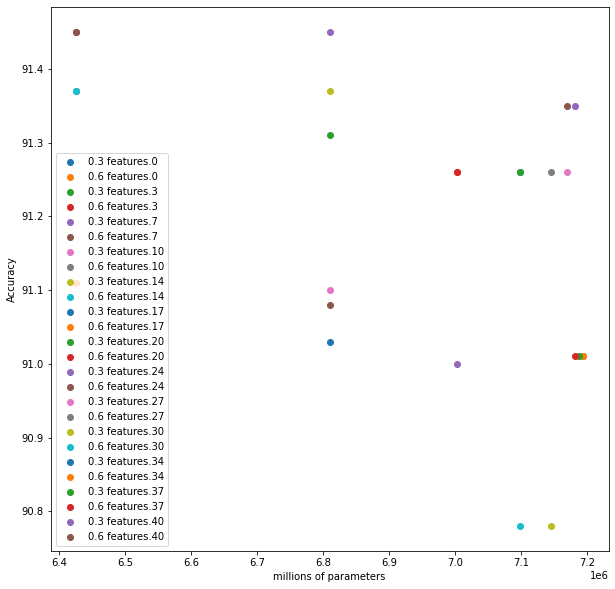

In [ ]:
print(list_dico)

figure=plt.figure(figsize=(10,10))

for key, value in list_dico.items() :
  #if key[:3]==str(0.3):

  print(key," : ",value["test_acc"]," ---- ",sum(value["nbr_param"]))
  plt.scatter(sum(value["nbr_param"]),value["test_acc"])

plt.legend(list_dico.keys())
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")

**Dans ce graphique nous pouvons observer les divers compromis entre accuracy et nombre de paramètres. Au vu du nombre de points, la lisibilité peut être difficile, le texte au dessus du graphique affiche les résultats précis du pruning de chacuns des layers.**

### Utilisation de ces résultats

**Nous pensions concatener les divers élagages de layers qui semblaient être intéressants ( Pour chaque layer on regarde quels sont les ratios permettant d'obtenir environ 91% d'accuracy avec le moins de paramètres possible). Cependant cette méthode n'a pas abouti**

**Nous avons donc essentiellement retenu que nous pouvions hautement pruner les hauts étages 70 à 80% et qu'il vallait mieux éviter de pruner les bas étages 10/20%. Au vu du faible nombre de paramètres économisés en prunant les bas layers, nous avons choisis de ne pas les pruner :**

In [ ]:
from google.colab import files
import numpy as np

try: 
  loaded_cpt = torch.load('checkpoint.pt')

except :
  
  #loaded_cpt = torch.load('C:/Users/Malo/Desktop/Cours/Fise_A2/S4/DeepL/prunage de layers sur cifar 10/checkpoint.pt',map_location=torch.device('cpu'))
  if True :


    print("Chargez les poids")
    files.upload()
    loaded_cpt = torch.load('checkpoint.pt')
net = VGG('VGG16')
  
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()
mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(loaded_cpt["net"])
#"features.0":0.2,
              #"features.3":0.2,
              #"features.7":0.3,
              #"features.10":0.3,
              #"features.14":0.3,

list_modules={ 
              "features.17":0.3,
              "features.20":0.3,
              "features.24":0.3,
              "features.27":0.6,
              "features.30":0.6,
              "features.34":0.6,
              "features.37":0.7,
              "features.40":0.7}

for key, value in list_modules.items() :  


  print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
  
  paramconv1,paramfc1= get_number_param_pruned(mymodel.model)
  mymodel.prune_spef_layer(key,value,2)
  paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
  print(paramconv2,paramfc2)

  print("parameters losed : ",sum([paramconv2,paramfc2])-sum([ paramconv1,paramfc1]))


valid_loss,training_loss,test_accuracy=[],[],[]
# entrainement a
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 10,criterion,optimizer,mymodel,scheduler=False ) 

     
    #entrainement b

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,15,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.17
7098108.0 510.0
parameters losed :  -96123.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.20
7001985.0 510.0
parameters losed :  -96123.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.24
6809739.0 510.0
parameters losed :  -192246.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.27
6040755.0 510.0
parameters losed :  -768984.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.30
5271771.0 510.0
parameters losed :  -768984.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.34
4502787.0 510.0
parameters losed :  -768984.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.37
3733803.0 510.0
parameters losed :  -768984.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
features.40
2964819.0 510.0
parameters losed :  -768984.0
epoch  0
saving weights.... 
83.48  % ,  0.45435957016944883  ,  0.611

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 



epoch  0
saving weights.... 
90.22  % ,  0.28221216628700496  ,  0.07299854901302606
epoch  1
saving weights.... 
90.48  % ,  0.29496109774708745  ,  0.07162552430070937
epoch  2
saving weights.... 
90.36  % ,  0.29217873817384243  ,  0.0653748398590833
epoch  3
saving weights.... 
90.48  % ,  0.3114155019775033  ,  0.06503173639141023
epoch  4
saving weights.... 
90.37  % ,  0.2940168977454305  ,  0.06459791488032789
epoch  5
saving weights.... 
90.33  % ,  0.30059139006137847  ,  0.06045272808149457
epoch  6
saving weights.... 
90.44  % ,  0.30311511041224004  ,  0.06116835808120668
epoch  7
saving weights.... 
90.53  % ,  0.30273729188740256  ,  0.05570056735472754
epoch  8
saving weights.... 
90.42  % ,  0.30185889819562434  ,  0.06009721760507673
epoch  9
saving weights.... 
90.29  % ,  0.3091937478750944  ,  0.05486445414824411
epoch  10
saving weights.... 
90.19  % ,  0.3008853645659983  ,  0.05403703319407068
epoch  11
saving weights.... 
90.18  % ,  0.3109047457953915  ,  0.05

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.0001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,15,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
saving weights.... 
90.63  % ,  0.30974034922719  ,  0.03493915862971917
epoch  1
saving weights.... 
90.75  % ,  0.31308472573310137  ,  0.029332946519088
epoch  2
saving weights.... 
90.82  % ,  0.29563098640553653  ,  0.029516348081082104
epoch  3
saving weights.... 
90.75  % ,  0.31201216403618454  ,  0.027539601940382272
epoch  4
saving weights.... 
90.81  % ,  0.3058175583511591  ,  0.026980595519393684
epoch  5
saving weights.... 
90.99  % ,  0.3084580358508974  ,  0.023788554584654047
epoch  6
saving weights.... 
90.95  % ,  0.3032103516958654  ,  0.024545495200762525
epoch  7
saving weights.... 
90.88  % ,  0.3066167630985379  ,  0.02351048816619441
epoch  8
saving weights.... 
91.09  % ,  0.3110354413598776  ,  0.02246576363942586
epoch  9
saving weights.... 
90.86  % ,  0.3087452600732446  ,  0.02125116143221967
epoch  10
saving weights.... 
91.03  % ,  0.3096977744370699  ,  0.021688511567236855
epoch  11
saving weights.... 
90.98  % ,  0.3088596345551312  ,  0.020

In [ ]:
state = {
            'net': mymodel.model.state_dict(),
            
            'optimizer': optimizer,
    }
torch.save(state, 'checkpoint_prdim2.pt')

In [ ]:
mymodel.remove_prune()
mesure_operation(mymodel.model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Nous avons ici divisé par 5 le nombre de paramètres, et le nombre d'opérations par 3.

## Prune sur la dim 0

**Nous avons essayés de réaliser la même expérience en élaguant sur la dimension 0 qui semblait être plus prometteuse. Nous avons aussi modifier notre procédé afin de ne pas retomber sur les problèmes précédents. Durant ce processus nous avons choisis de traiter notre réseau layer par layer : nous élaguons un layer au maximum, et si le résultats est satisfaisant, nous passons au layers suivant en gardant le modèle obtenu. Nous n'avons malheureusement pas eu le temps de finir le procédé.**

In [ ]:
from google.colab import files
import numpy as np
import io
data_int=False
def prune_fine_tune(ind_module,ratio_conv=[0.3,0.6]):
  
  try: 
    loaded_cpt = torch.load('checkpoint_prdim2_temp.pt')

  except :
    
    #loaded_cpt = torch.load('C:/Users/Malo/Desktop/Cours/Fise_A2/S4/DeepL/prunage de layers sur cifar 10/checkpoint.pt',map_location=torch.device('cpu'))
    if True :


      print("Chargez les poids : checkpoint_prdim2_temp.pt")
      files.upload()
      loaded_cpt = torch.load('checkpoint_prdim2_temp.pt')

  net = VGG('VGG16')
  
  if data_int :
    net.half()
  mymodel = my_network_with_trous(net)
  mymodel.model = mymodel.model.to(device)
  criterion = nn.CrossEntropyLoss()

  list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]
  module=list_modules[ind_module]
  for ratios in ratio_conv :  
    print("________________________________________________________")
    print("setting ratio to ",ratios)
    
    valid_loss,training_loss,test_accuracy=[],[],[]
    

    mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})

    mymodel.model.load_state_dict(loaded_cpt["net"])

    paramconv1,paramfc1= get_number_param_pruned(mymodel.model)
    mymodel.prune_spef_layer(module,ratios,2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)
    print("parameters losed : ",sum([paramconv2,paramfc2])-sum([ paramconv1,paramfc1]))

    print(mymodel.model)
    # entrainement a

    optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
    valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 
    #if False :
    if not max(test_accuracy)< 15 :
      valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 5,criterion,optimizer,mymodel,scheduler=False ) 
    #entrainement b

      optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
      valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 
    else : 
      print("cut training because useless")
    print("On save (o) ou on coupe (n) ?")
    rep=str(input())
    if rep=="o":
      loaded_cpt = torch.load('temp.pt')


      mymodel.model.load_state_dict(loaded_cpt["net"])
      state = {
            'net': mymodel.model.state_dict(),
    }
      torch.save(state, 'checkpoint_prdim2_temp.pt')
      #files.download('checkpoint_prdim2_temp.pt')

    elif rep=="n" :
      return None



### Prune sur "features.40"


In [ ]:
prune_fine_tune(12,[0.3,0.4,0.5,0.6,0.8,0.875])


________________________________________________________
setting ratio to  0.3
Pruning....
features.40
2964819.0 510.0
parameters losed :  0.0
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

### Prune sur "features.37"


In [ ]:
prune_fine_tune(11,[0.3,0.6,0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
features.37
2964819.0 510.0
parameters losed :  0.0
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

RuntimeError: ignored

# Quantization et mesure des paramètres de différents réseaux.


**Ce code ci correspond à l'étude que j'ai réalisé pour Maxence afin de mesurer le nombre de paramètres des réseaux obtenus à travers l'élagage de mobile net. Nous avons aussi essayé de rajouter de la quantization à nos réseaux afin d'optimiser encore plus leur taille.**

## class BC

**Cette classe BC ( Binary Connect) a pour but de transformer les poids du réseau en poids binaires**

In [ ]:
### See http://papers.nips.cc/paper/5647-binaryconnect-training-deep-neural-networks-with-b
### for a complete description of the algotihm 


#  
import torch.nn as nn
import numpy
from torch.autograd import Variable


class BC():
    def __init__(self, model):

        # First we need to 
        # count the number of Conv2d and Linear
        # This will be used next in order to build a list of all 
        # parameters of the model 

        count_targets = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                count_targets = count_targets + 1

        start_range = 0
        end_range = count_targets-1
        self.bin_range = numpy.linspace(start_range,
                end_range, end_range-start_range+1)\
                        .astype('int').tolist()

        # Now we can initialize the list of parameters

        self.num_of_params = len(self.bin_range)
        self.saved_params = [] # This will be used to save the full precision weights
        
        self.target_modules = [] # this will contain the list of modules to be modified

        self.model = model # this contains the model that will be trained and quantified

        ### This builds the initial copy of all parameters and target modules
        index = -1
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                index = index + 1
                if index in self.bin_range:
                    tmp = m.weight.data.clone()
                    self.saved_params.append(tmp)
                    self.target_modules.append(m.weight)


    def save_params(self):

        ### This loop goes through the list of target modules, and saves the corresponding weights into the list of saved_parameters

        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)
            

    def binarization(self):

        ### To be completed

        ### (1) Save the current full precision parameters using the save_params method
        self.save_params()

        
        
        ### (2) Binarize the weights in the model, by iterating through the list of target modules and overwrite the values with their binary version
        #for i in self.target_modules :
          #print(i)
          #i=torch.div(i,torch.abs(i))
          #current_torch_tensor=self.model[i].weight.data
          #new_binary_weights=torch.div(current_torch_tensor,torch.abs(current_torch_tensor))
          #self.model[i].weight.data.copy_(new_binary_weights)
          # Rentrer les poids dans le réseau ?

        for index in range(self.num_of_params):
            #self.target_modules[index].data.copy_(torch.where(self.target_modules[index]>0, 1, -1))
            self.target_modules[index].data.copy_(self.target_modules[index].data.sign())
        #J'ai une erreur c'est la même chose que ce que t'avais fais au dessus, d'ailleurs je suis chaud on demande à un prof dans la journée de
        #vendredi
        #for module in range(self.num_of_params) :
        #  self.model[module].weight.data.copy_(torch.div(self.model.module.weight.data,abs(self.model.module.weight.data)))
            
          
          
        

    def restore(self):

        ### restore the copy from self.saved_params into the model 

        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])
      
    def clip(self):

        ## To be completed 
        ## Clip all parameters to the range [-1,1] using Hard Tanh 
        ## you can use the nn.Hardtanh function
        clip_scale=[]
        m=nn.Hardtanh(-1, 1)
        for index in range(self.num_of_params):
            clip_scale.append(m(Variable(self.target_modules[index].data)))
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(clip_scale[index].data)
            #a=self.target_modules[index].data            
            #self.target_modules[index].data.copy_(hth(a))
        #self.model.weight.data.copy_(nn.Hardtanh(model.weight.data))


    def forward(self,x):

        ### This function is used so that the model can be used while training
        out = self.model(x)
        return out

## training func BC

In [ ]:


def trainingwithBC(trainloader,validloader,testloader,n_epochs,criterion,optimizer,mymodel,valid_losses=[],training_losses=[],test_accuracys=[],scheduler=True) : 
  
  
  mymodelbc = BC(net)
  mymodelbc.model = mymodelbc.model.to(device)
  
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
      train_loss,valid_loss=0,0
      
      print("epoch ",epoch)

      running_loss = 0.0
      mymodelbc.model.train()

      for data,label in trainloader:
          
          if data_int :
              data=data.half()
          # zero the parameter gradients
          
          optimizer.zero_grad()

          # forward + backward + optimize
          mymodelbc.binarization()
          #outputs = net(inputs.to(device))
          outputs = mymodelbc.forward(data.to(device))
          #print("outputs",outputs)
          
          #print("labels",labels)
          loss = criterion(outputs, label.to(device))

          loss.backward()
          mymodelbc.restore()

          optimizer.step()
          mymodelbc.clip()
          # print statistics
          train_loss += loss.item()*data.size(0)

          
      mymodelbc.model.eval()
      for data,label in validloader:


          if data_int :
              data=data.half()
          
          outputs = mymodelbc.forward(data.to(device))

          loss = criterion(outputs, label.to(device))

          # print statistics
          valid_loss += loss.item()*data.size(0)

      train_loss /= len(trainloader.sampler)
      valid_loss /= len(validloader.sampler)
      training_losses.append(train_loss)
     

      #lr_scheduler.step(running_loss/i)        
      valid_losses.append(valid_loss)
      

      if valid_loss==min(valid_losses) :
        print("saving weights.... ")
        state = {'net': mymodelbc.model.state_dict()}


        torch.save(state, 'temp.pt')
      
      test_accuracy=eval_accuracy(mymodelbc.model,testloader )

      print(test_accuracy," % , ",valid_losses[-1]," , ",training_losses[-1])
      test_accuracys.append(test_accuracy)

  #print(training_losses)
  print('Finished Training')
  return valid_losses,training_losses, test_accuracys, mymodelbc




      

## Mobile Net

Ici on met en place mobile net

In [ ]:
import math
import torch.nn.functional as F


class BaseBlock(nn.Module):
    alpha = 1

    def __init__(self, input_channel, output_channel, t = 6, downsample = False):
        """
            t:  expansion factor, t*input_channel is channel of expansion layer
            alpha:  width multiplier, to get thinner models
            rho:    resolution multiplier, to get reduced representation
        """ 
        super(BaseBlock, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (input_channel == output_channel) 

        # apply alpha
        input_channel = int(self.alpha * input_channel)
        output_channel = int(self.alpha * output_channel)
        
        # for main path:
        c  = t * input_channel
        # 1x1   point wise conv
        self.conv1 = nn.Conv2d(input_channel, c, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(c)
        # 3x3   depth wise conv
        self.conv2 = nn.Conv2d(c, c, kernel_size = 3, stride = self.stride, padding = 1, groups = c, bias = False)
        self.bn2 = nn.BatchNorm2d(c)
        # 1x1   point wise conv
        self.conv3 = nn.Conv2d(c, output_channel, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channel)
        

    def forward(self, inputs):
        # main path
        x = F.relu6(self.bn1(self.conv1(inputs)), inplace = True)
        x = F.relu6(self.bn2(self.conv2(x)), inplace = True)
        x = self.bn3(self.conv3(x))

        # shortcut path
        x = x + inputs if self.shortcut else x

        return x


class MobileNetV2(nn.Module):
    def __init__(self, output_size, alpha = 1):
        super(MobileNetV2, self).__init__()
        self.output_size = output_size

        # first conv layer 
        self.conv0 = nn.Conv2d(3, int(32*alpha), kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn0 = nn.BatchNorm2d(int(32*alpha))

        # build bottlenecks
        BaseBlock.alpha = alpha
        self.bottlenecks = nn.Sequential(
            BaseBlock(32, 16, t = 1, downsample = False),
            BaseBlock(16, 24, downsample = False),
            BaseBlock(24, 24),
            BaseBlock(24, 32, downsample = False),
            BaseBlock(32, 32),
            BaseBlock(32, 32),
            BaseBlock(32, 64, downsample = True),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 96, downsample = False),
            BaseBlock(96, 96),
            BaseBlock(96, 96),
            BaseBlock(96, 160, downsample = True),
            BaseBlock(160, 160),
            BaseBlock(160, 160),
            BaseBlock(160, 320, downsample = False))

        # last conv layers and fc layer
        self.conv1 = nn.Conv2d(int(320*alpha), 1280, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.fc = nn.Linear(1280, output_size)

        # weights init
        self.weights_init()


    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, inputs):

        # first conv layer
        x = F.relu6(self.bn0(self.conv0(inputs)), inplace = True)
        # assert x.shape[1:] == torch.Size([32, 32, 32])

        # bottlenecks
        x = self.bottlenecks(x)
        # assert x.shape[1:] == torch.Size([320, 8, 8])

        # last conv layer
        x = F.relu6(self.bn1(self.conv1(x)), inplace = True)
        # assert x.shape[1:] == torch.Size([1280,8,8])

        # global pooling and fc (in place of conv 1x1 in paper)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x


## Calculs

In [ ]:
net = MobileNetV2(10, alpha=1)
mymodeltrous = my_network_with_trous(net)
mymodeltrous.model = mymodeltrous.model.to(device)

#mymodel.remove_prune()
mesure_operation(mymodeltrous.model)

tensor([1.])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=864, operations=1736704
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([1.])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=1024, operations=2064384
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([1.])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=288, operations=18841600
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([1.])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=512, operations=1032192
Batch norm: F_in=16 P=1024, params=32, operations=49152
tensor([1.])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=1536, operations=3047424
Batch norm: F_in=96 P=1024, params=192, operations=294912
tensor([1.])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=864, operations=169771008
Batch norm: F_in=96 P=1024, params=192, operations=294912
tensor([1.])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=2304, operations=4694016
Batch norm: F_in=24 P=1024, params=48, operations=737

**La fonction profile ne semble pas bien marcher avec notre fonction profile. Nous avons donc calculé à la main le nombre de paramètres et d'opérations**

In [ ]:
paramconv2,paramfc2=get_number_param_pruned(mymodeltrous.model)
print(paramconv2,paramfc2)

12383528960.0 38380.0


In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_kd_45k.pt',map_location=torch.device('cpu')))

paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
print(paramconv2,paramfc2)
print("_____________________________")
mymodel.remove_prune()
mesure_operation(mymodel.model)







Pruning....


FileNotFoundError: ignored

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()


mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
net.load_state_dict(torch.load('mnet_cifar10_kd_45k.pt'))




Pruning....


<All keys matched successfully>

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss, test_accuracys,mymodelbc =trainingwithBC(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel.model,scheduler=True)

#c10trainloader,c10validloader,c10testloader, 5,criterion,optimizer,mymodel,scheduler=False

#valid_loss,training_loss = trainingwithBC(trainloader,validloader,testloader,n_epochs,criterion,optimizer,mymodel,valid_losses=[],training_losses=[],test_accuracys=[],scheduler=False)

epoch  0
saving weights.... 
72.88  % ,  0.7822838376998902  ,  0.9869044678688049
epoch  1
saving weights.... 
73.82  % ,  0.7524137049198151  ,  0.765453828883171
epoch  2
saving weights.... 
76.59  % ,  0.6903407567977905  ,  0.7132915166378021
epoch  3
73.96  % ,  0.7751262371063232  ,  0.6784958131432534
epoch  4
75.57  % ,  0.7102547716379166  ,  0.6654510382413864
epoch  5
75.95  % ,  0.7130450839042664  ,  0.6480537532329559
epoch  6
saving weights.... 
78.3  % ,  0.6415948032379151  ,  0.6328354204416275
epoch  7
77.59  % ,  0.666321591091156  ,  0.6202680255770683
epoch  8
76.9  % ,  0.6593455308914185  ,  0.6202920879483222
epoch  9
74.37  % ,  0.7066953675746918  ,  0.6117789582133293
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss, test_accuracys,mymodelbc =trainingwithBC(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel.model,scheduler=True)

epoch  0
saving weights.... 
83.71  % ,  0.4738486004829407  ,  0.5123840938329697
epoch  1
saving weights.... 
84.07  % ,  0.4545268725395203  ,  0.4767132646083832
epoch  2
saving weights.... 
84.27  % ,  0.45004876613616945  ,  0.4630650124490261
epoch  3
saving weights.... 
84.16  % ,  0.44247387070655825  ,  0.4566440619289875
epoch  4
84.5  % ,  0.4457044666290283  ,  0.44601684743762016
epoch  5
saving weights.... 
84.74  % ,  0.44216122627258303  ,  0.4379204518556595
epoch  6
saving weights.... 
84.75  % ,  0.44173378405570984  ,  0.43792219467163085
epoch  7
saving weights.... 
84.87  % ,  0.43764058656692506  ,  0.4338350251555443
epoch  8
84.81  % ,  0.43778069727420804  ,  0.4279998685121536
epoch  9
saving weights.... 
85.15  % ,  0.4298067883014679  ,  0.42163462193012236
epoch  10
84.84  % ,  0.43408133068084714  ,  0.4212979472666979
epoch  11
84.48  % ,  0.43332903821468355  ,  0.41755607865452765
epoch  12
saving weights.... 
84.92  % ,  0.42847662844657897  ,  0.419

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.0001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss, test_accuracys,mymodelbc =trainingwithBC(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel.model,scheduler=True)

epoch  0
saving weights.... 
85.6  % ,  0.41475571715831755  ,  0.3807285984933376
epoch  1
85.88  % ,  0.42202863163948057  ,  0.3747621378779411
epoch  2
saving weights.... 
85.7  % ,  0.40774750497341156  ,  0.3756208316862583
epoch  3
85.78  % ,  0.4120748637020588  ,  0.37337535467147825
epoch  4
saving weights.... 
85.75  % ,  0.405747878241539  ,  0.3664504172325134
epoch  5
85.81  % ,  0.4090512107133865  ,  0.3736821874260902
epoch  6
85.91  % ,  0.4131540148735046  ,  0.368728474843502
epoch  7
85.73  % ,  0.40760580666065216  ,  0.3680179129362106
epoch  8
85.91  % ,  0.4081586042642593  ,  0.3676912004947662
epoch  9
85.7  % ,  0.4068161660194397  ,  0.36449916853010655
epoch  10
86.06  % ,  0.41234762091636656  ,  0.36458342278599737
epoch  11
85.7  % ,  0.411593772482872  ,  0.3600827035307884
epoch  12
saving weights.... 
85.7  % ,  0.40499977898597717  ,  0.3638759257912636
epoch  13
saving weights.... 
85.76  % ,  0.40333805665969846  ,  0.3637527884632349
epoch  14
85

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.00005, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss, test_accuracys,mymodelbc =trainingwithBC(c10trainloader,c10validloader,c10testloader,1,criterion,optimizer,mymodel.model,scheduler=True)

epoch  0
saving weights.... 
85.97  % ,  0.4078996299028397  ,  0.35855594984889033
Finished Training


In [ ]:
mymodelbc.restore()
mymodelbc.save_params()
mymodelbc.binarization() ## This binarizes all weights in the model
mymodelbc.clip()

test_accuracy=eval_accuracy(mymodelbc.model,testloader )
print(test_accuracy)
#

"""
  for name, module in model.named_modules():
    

      l=list(module.named_buffers())

      total_conv+=torch.sum(l[0][1].type(torch.DoubleTensor)).item()
      #print(len(l[0][1]))
       
    elif isinstance(module, torch.nn.Linear):

      l=list(module.named_buffers())
      #print(torch.sum(l[0][1]).item())

      total_fc+=torch.sum(l[0][1]).item()

pp=0
"""

65.225


'\n  for name, module in model.named_modules():\n    \n\n      l=list(module.named_buffers())\n\n      total_conv+=torch.sum(l[0][1].type(torch.DoubleTensor)).item()\n      #print(len(l[0][1]))\n       \n    elif isinstance(module, torch.nn.Linear):\n\n      l=list(module.named_buffers())\n      #print(torch.sum(l[0][1]).item())\n\n      total_fc+=torch.sum(l[0][1]).item()\n\npp=0\n'

In [ ]:


for name, module in mymodelbc.model.named_modules():
  print(name)
  if isinstance(module, torch.nn.Conv2d):
    l=list(module.named_parameters())
    #total_conv+=torch.sum(l[0][1].type(torch.DoubleTensor)).item()
    print(l[0][1])
    a=torch.where(l[0][1] > 0.8, 1., 0.)
    #print(torch.sum(a))
   
    #print(torch.sum(l[0][1]))


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

         [[-1.3242e-11]],

         [[-2.1880e-06]],

         [[ 4.1464e-11]],

         [[-3.9289e-11]],

         [[ 3.5524e-11]],

         [[-5.0804e-08]],

         [[ 7.1862e-07]],

         [[-1.2582e-11]],

         [[ 1.0913e-11]],

         [[-1.1381e-04]],

         [[ 2.0323e-03]],

         [[-1.5678e-09]],

         [[-1.9779e-12]],

         [[ 1.1849e-06]]],


        [[[-2.8542e-11]],

         [[-9.4109e-10]],

         [[ 7.3518e-08]],

         [[ 2.9445e-11]],

         [[ 1.9720e-11]],

         [[-3.1382e-11]],

         [[-2.1551e-08]],

         [[-5.3991e-09]],

         [[ 1.7716e-08]],

         [[-7.7827e-12]],

         [[-2.6924e-08]],

         [[-1.0180e-08]],

         [[ 8.9153e-12]],

         [[ 2.5994e-08]],

         [[ 8.1400e-09]],

         [[-1.0876e-10]],

         [[ 9.2376e-11]],

         [[-7.3939e-09]],

         [[ 4.3737e-11]],

         [[-2.7187e-08]],

 

Bien que les résultats du Binary COnnect appliqué à mobile net semble intéressants, après étude des poids nous avons vu qu'ils n'étaient pas binarisés...

## half sur nos réseaux

On applique ici une quantization 32 bits aux réseaux qui présente de l'intérêt à notre avis

### 45k

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_kd_45k.pt',map_location=torch.device('cpu')))



mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")

Pruning....
tensor([0.0833])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=36, operations=107861
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0156])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=8, operations=24064
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.1250])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=18, operations=1765376
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0156])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=4, operations=12032
Batch norm: F_in=16 P=1024, params=16, operations=49152
tensor([0.0156])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=12, operations=35328
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.1250])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=54, operations=15912960
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.0156])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=18, operations=54912
Batch norm: F_in=24 P=1024, params=24,

In [ ]:
data_int=True
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_kd_45k.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()




valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
saving weights.... 
67.58  % ,  0.951640625  ,  0.99979091796875
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
saving weights.... 
74.58  % ,  0.749175390625  ,  0.7881087890625
epoch  1
saving weights.... 
74.66  % ,  0.74453984375  ,  0.732587109375
epoch  2
73.32  % ,  0.7542609375  ,  0.69352216796875
epoch  3
saving weights.... 
76.67  % ,  0.67958984375  ,  0.686780078125
epoch  4
saving weights.... 
77.9  % ,  0.66290703125  ,  0.6719482421875
epoch  5
saving weights.... 
78.6  % ,  0.6343125  ,  0.6599123046875
epoch  6
saving weights.... 
79.24  % ,  0.629033984375  ,  0.64786826171875
epoch  7
72.94  % ,  0.8068328125  ,  0.644325390625
epoch  8
75.88  % ,  0.703375  ,  0.63085458984375
epoch  9
77.33  % ,  0.65828671875  ,  0.6273140625
epoch  10
76.21  % ,  0.69695859375  ,  0.616440625
epoch  11
78.62  % ,  0.651365625  ,  0.61372666015625
epoch  12
75.78  % ,  0.70234609375  ,  0.61296455078125
epoch  13
77.58  % ,  0.663975  ,  0.5972353515625
epoch  14
77.06  % ,  0.673258203125  ,  0.60660205078125
epoch  15
saving weights.... 
79.1  % ,  0.62759453125  ,  0.5942736328

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
saving weights.... 
84.77  % ,  0.453483203125  ,  0.47350751953125
epoch  1
saving weights.... 
84.95  % ,  0.434588671875  ,  0.430129150390625
epoch  2
saving weights.... 
85.2  % ,  0.43351796875  ,  0.417379052734375
epoch  3
saving weights.... 
85.63  % ,  0.4293400390625  ,  0.410043798828125
epoch  4
saving weights.... 
85.62  % ,  0.4196998046875  ,  0.401387548828125
epoch  5
86.25  % ,  0.4243568359375  ,  0.39577939453125
epoch  6
saving weights.... 
85.85  % ,  0.4167611328125  ,  0.391538916015625
epoch  7
saving weights.... 
85.94  % ,  0.414596875  ,  0.388394189453125
epoch  8
86.66  % ,  0.41995703125  ,  0.382406884765625
epoch  9
saving weights.... 
86.31  % ,  0.411021875  ,  0.38247509765625
Finished Training


### 68k

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('checkpointmnet_cifar10_kd_68k.pt',map_location=torch.device('cpu')))



mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")

Pruning....
tensor([0.1042])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=45, operations=134826
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0234])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=12, operations=36096
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.1528])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=22, operations=2157681
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0195])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=5, operations=15040
Batch norm: F_in=16 P=1024, params=16, operations=49152
tensor([0.0195])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=15, operations=44160
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.1551])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=67, operations=19743858
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.0260])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=30, operations=91520
Batch norm: F_in=24 P=1024, params=24

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('checkpointmnet_cifar10_kd_68k.pt',map_location=torch.device('cpu')))




print(eval_accuracy(mymodel.model,c10testloader))

Pruning....
89.11


In [ ]:
data_int=True
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_kd_68k.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()




valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
68.14  % ,  0.929415625  ,  0.9984505859375
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
71.64  % ,  0.8596  ,  0.789081640625
epoch  1
75.14  % ,  0.722784375  ,  0.7319400390625
epoch  2
75.61  % ,  0.724984375  ,  0.7066099609375
epoch  3
74.76  % ,  0.73442890625  ,  0.67573310546875
epoch  4
74.81  % ,  0.72003515625  ,  0.66013564453125
epoch  5
75.06  % ,  0.71742578125  ,  0.6479560546875
epoch  6
76.71  % ,  0.715137109375  ,  0.63591474609375
epoch  7
76.04  % ,  0.68206796875  ,  0.63283828125
epoch  8
78.48  % ,  0.654242578125  ,  0.625721875
epoch  9
76.83  % ,  0.68983125  ,  0.62082421875
epoch  10
77.17  % ,  0.641733203125  ,  0.61616171875
epoch  11
77.41  % ,  0.6840390625  ,  0.6149458984375
epoch  12
77.45  % ,  0.6428265625  ,  0.6082552734375
epoch  13
77.95  % ,  0.63481171875  ,  0.60747138671875
epoch  14
79.69  % ,  0.589803515625  ,  0.60443486328125
epoch  15
76.78  % ,  0.67206328125  ,  0.5999828125
epoch  16
80.35  % ,  0.59741640625  ,  0.6020232421875
epoch  17


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 8,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
78.04  % ,  0.656537890625  ,  0.5959181640625
epoch  1
79.09  % ,  0.622998828125  ,  0.59561494140625
epoch  2
79.68  % ,  0.610316015625  ,  0.59540224609375
epoch  3
79.56  % ,  0.6109103515625  ,  0.597985546875
epoch  4
80.47  % ,  0.591781640625  ,  0.596171484375
epoch  5
79.19  % ,  0.61143515625  ,  0.58944013671875
epoch  6
78.54  % ,  0.622975390625  ,  0.5920076171875
epoch  7
78.75  % ,  0.634009375  ,  0.59277392578125
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
84.36  % ,  0.465015625  ,  0.4789638671875
epoch  1
84.8  % ,  0.4531296875  ,  0.432490234375
epoch  2
85.3  % ,  0.439956640625  ,  0.420766796875
epoch  3
85.4  % ,  0.4329140625  ,  0.4096037109375
epoch  4
85.3  % ,  0.42796171875  ,  0.404459619140625
epoch  5
85.54  % ,  0.433471875  ,  0.39996181640625
epoch  6
85.54  % ,  0.419629296875  ,  0.3944962890625
epoch  7
85.58  % ,  0.421043359375  ,  0.385657080078125
epoch  8
85.82  % ,  0.4197306640625  ,  0.38346376953125
epoch  9
85.47  % ,  0.4260857421875  ,  0.38232138671875
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
85.94  % ,  0.4172732421875  ,  0.380199951171875
epoch  1
85.47  % ,  0.4169791015625  ,  0.376739892578125
epoch  2
86.11  % ,  0.420416796875  ,  0.373740869140625
epoch  3
saving weights.... 
85.7  % ,  0.410644921875  ,  0.37342724609375
epoch  4
85.99  % ,  0.4152974609375  ,  0.370627880859375
epoch  5
saving weights.... 
85.74  % ,  0.410621875  ,  0.368991943359375
epoch  6
saving weights.... 
85.96  % ,  0.4055537109375  ,  0.369993798828125
epoch  7
86.02  % ,  0.41183515625  ,  0.3633412109375
epoch  8
86.01  % ,  0.4155869140625  ,  0.365323486328125
epoch  9
85.87  % ,  0.4148583984375  ,  0.36306025390625
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.0001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
86.25  % ,  0.409061328125  ,  0.355794189453125
epoch  1
85.9  % ,  0.4117482421875  ,  0.352028515625
epoch  2
86.22  % ,  0.407715234375  ,  0.352715576171875
epoch  3
saving weights.... 
86.22  % ,  0.4053765625  ,  0.3458421875
epoch  4
saving weights.... 
86.49  % ,  0.4047259765625  ,  0.3476559814453125
epoch  5
saving weights.... 
86.29  % ,  0.3983556640625  ,  0.343079150390625
epoch  6
86.3  % ,  0.401123046875  ,  0.346611083984375
epoch  7
86.3  % ,  0.405167578125  ,  0.346972705078125
epoch  8
86.37  % ,  0.399871875  ,  0.33999609375
epoch  9
86.43  % ,  0.405915625  ,  0.344748046875
Finished Training


### 250k

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_250k.pt',map_location=torch.device('cpu')))



mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")

Pruning....
tensor([0.2083])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=90, operations=269653
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0977])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=50, operations=150400
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.3125])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=45, operations=4413440
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.0977])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=25, operations=75200
Batch norm: F_in=16 P=1024, params=16, operations=49152
tensor([0.0977])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=75, operations=220800
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.3125])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=135, operations=39782400
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.1042])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=120, operations=366080
Batch norm: F_in=24 P=1024, par

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_250k.pt',map_location=torch.device('cpu')))

print(eval_accuracy(mymodel.model,c10testloader))

Pruning....
91.14


In [ ]:
data_int=True
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_250k.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()




valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
83.97  % ,  0.4252779296875  ,  0.457237841796875
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
84.2  % ,  0.448318359375  ,  0.439951953125
epoch  1
84.3  % ,  0.4407103515625  ,  0.43315615234375
epoch  2
83.45  % ,  0.465434765625  ,  0.419251416015625
epoch  3
83.09  % ,  0.4650162109375  ,  0.42665068359375
epoch  4
85.1  % ,  0.425803125  ,  0.423358251953125
epoch  5
85.26  % ,  0.403140234375  ,  0.4287947509765625
epoch  6
84.68  % ,  0.4421681640625  ,  0.425832080078125
epoch  7
84.13  % ,  0.4629896484375  ,  0.428233642578125
epoch  8
83.01  % ,  0.48621552734375  ,  0.421339794921875
epoch  9
81.9  % ,  0.5007568359375  ,  0.425131298828125
epoch  10
85.07  % ,  0.4381736328125  ,  0.422677587890625
epoch  11
84.53  % ,  0.434758984375  ,  0.4167341796875
epoch  12
83.33  % ,  0.47806953125  ,  0.424689892578125
epoch  13
84.89  % ,  0.4280552734375  ,  0.4198611328125
epoch  14
85.26  % ,  0.438326953125  ,  0.422596240234375
epoch  15
84.57  % ,  0.4497509765625  ,  0.421431005859375
epoch  16
84.07  % ,  0.446935546875  ,  0.428239013671875
epoch  17
85.

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
saving weights.... 
89.62  % ,  0.30145107421875  ,  0.30467763671875
epoch  1
saving weights.... 
90.03  % ,  0.285808203125  ,  0.258798828125
epoch  2
saving weights.... 
90.39  % ,  0.27697437744140624  ,  0.247108984375
epoch  3
saving weights.... 
90.03  % ,  0.27376337890625  ,  0.233851611328125
epoch  4
saving weights.... 
90.17  % ,  0.27175400390625  ,  0.2245684326171875
epoch  5
saving weights.... 
90.5  % ,  0.265438671875  ,  0.2229976806640625
epoch  6
saving weights.... 
90.61  % ,  0.26212060546875  ,  0.2125527099609375
epoch  7
90.42  % ,  0.262145263671875  ,  0.210363134765625
epoch  8
saving weights.... 
90.75  % ,  0.26116435546875  ,  0.20753099365234376
epoch  9
saving weights.... 
90.87  % ,  0.252710546875  ,  0.2019739501953125
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

epoch  0
90.72  % ,  0.25936923828125  ,  0.19746005859375
epoch  1
90.78  % ,  0.256189013671875  ,  0.19698758544921874
epoch  2
90.74  % ,  0.2542048828125  ,  0.1984523681640625
epoch  3
91.04  % ,  0.25916318359375  ,  0.1914765380859375
epoch  4
90.94  % ,  0.26081494140625  ,  0.18764398193359375
epoch  5
saving weights.... 
90.99  % ,  0.24860859375  ,  0.18425377197265624
epoch  6
90.92  % ,  0.24914287109375  ,  0.18383046875
epoch  7
90.93  % ,  0.252965771484375  ,  0.17895667724609374
epoch  8
90.99  % ,  0.2503494140625  ,  0.18241988525390626
epoch  9
91.05  % ,  0.2547103515625  ,  0.1785185791015625
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.0001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 

### 500k

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_500k.pt',map_location=torch.device('cpu')))



mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")

Pruning....
tensor([0.3333])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=144, operations=431445
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.2500])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=128, operations=385024
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.5000])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=72, operations=7061504
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([0.2500])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=64, operations=192512
Batch norm: F_in=16 P=1024, params=16, operations=49152
tensor([0.2500])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=192, operations=565248
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.5000])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=216, operations=63651840
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([0.2500])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=288, operations=878592
Batch norm: F_in=24 P=1024,

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_500k.pt',map_location=torch.device('cpu')))

print(eval_accuracy(mymodel.model,c10testloader))

Pruning....
91.8


In [ ]:
data_int=True
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_500k.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()




valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
83.26  % ,  0.436076953125  ,  0.428305859375
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
84.24  % ,  0.43582578125  ,  0.40821025390625
epoch  1
85.53  % ,  0.4098771484375  ,  0.402265087890625
epoch  2
84.76  % ,  0.4551380859375  ,  0.4013587890625
epoch  3
84.69  % ,  0.4414552734375  ,  0.403194482421875
epoch  4
85.75  % ,  0.3937130859375  ,  0.394665576171875
epoch  5
86.76  % ,  0.384089453125  ,  0.390714404296875
epoch  6
86.47  % ,  0.403701171875  ,  0.39056334228515627
epoch  7
85.55  % ,  0.39702724609375  ,  0.3927271484375
epoch  8
85.14  % ,  0.41624140625  ,  0.3889236328125
epoch  9
85.32  % ,  0.4236015625  ,  0.39325390625
epoch  10
85.23  % ,  0.427569921875  ,  0.3911814453125
epoch  11
85.3  % ,  0.416136328125  ,  0.387389208984375
epoch  12
85.17  % ,  0.4395765625  ,  0.383902490234375
epoch  13
85.63  % ,  0.404353515625  ,  0.383990380859375
epoch  14
84.39  % ,  0.4083197265625  ,  0.392638818359375
epoch  15
86.16  % ,  0.4046498046875  ,  0.3920455078125
epoch  16
81.7  % ,  0.50402265625  ,  0.390272509765625
epoch  17
85.03  % , 

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 15,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
90.24  % ,  0.275444140625  ,  0.2657078125
epoch  1
90.75  % ,  0.2619583984375  ,  0.220584326171875
epoch  2
90.92  % ,  0.25004404296875  ,  0.2090855224609375
epoch  3
90.99  % ,  0.2489447265625  ,  0.198292431640625
epoch  4
saving weights.... 
91.11  % ,  0.23826337890625  ,  0.19119903564453125
epoch  5
91.2  % ,  0.2414296875  ,  0.18436785888671875
epoch  6
saving weights.... 
91.54  % ,  0.23666787109375  ,  0.18117882080078124
epoch  7
saving weights.... 
91.68  % ,  0.235828271484375  ,  0.172925439453125
epoch  8
91.52  % ,  0.2359166015625  ,  0.16814989013671874
epoch  9
saving weights.... 
91.6  % ,  0.23331572265625  ,  0.165990283203125
epoch  10
91.43  % ,  0.236915625  ,  0.16245931396484375
epoch  11
saving weights.... 
91.52  % ,  0.226235546875  ,  0.16195107421875
epoch  12
91.59  % ,  0.232803662109375  ,  0.15408988037109375
epoch  13
91.71  % ,  0.22919580078125  ,  0.1552059326171875
epoch  14
saving weights.... 
91.54  % ,  0.226234765625  ,  0.1

### Mobile net de base

In [ ]:
data_int=False
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

#mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnetKd_cifar10.pt',map_location=torch.device('cpu')))



#mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")

tensor([1.])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=432, operations=1294336
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([1.])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=512, operations=1540096
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([1.])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=144, operations=14123008
Batch norm: F_in=32 P=1024, params=32, operations=98304
tensor([1.])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=256, operations=770048
Batch norm: F_in=16 P=1024, params=16, operations=49152
tensor([1.])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=768, operations=2260992
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([1.])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=432, operations=127303680
Batch norm: F_in=96 P=1024, params=96, operations=294912
tensor([1.])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=1152, operations=3514368
Batch norm: F_in=24 P=1024, params=24, operations=73728
te

In [ ]:
data_int=True
net = MobileNetV2(10, alpha=1)
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('mnet_cifar10_500k.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()




valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
saving weights.... 
83.6  % ,  0.42083984375  ,  0.4364951171875
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
84.48  % ,  0.423961328125  ,  0.418491845703125
epoch  1
saving weights.... 
84.62  % ,  0.41185703125  ,  0.403348876953125
epoch  2
83.78  % ,  0.431893359375  ,  0.398962255859375
epoch  3
saving weights.... 
84.75  % ,  0.3962326171875  ,  0.39889296875
epoch  4
saving weights.... 
86.15  % ,  0.3813916015625  ,  0.392094384765625
epoch  5
saving weights.... 
85.82  % ,  0.3733484375  ,  0.392160302734375
epoch  6
84.31  % ,  0.4355515625  ,  0.394030419921875
epoch  7
85.21  % ,  0.4021943359375  ,  0.388679736328125
epoch  8
84.54  % ,  0.4140033203125  ,  0.40240595703125
epoch  9
85.74  % ,  0.3930517578125  ,  0.396212109375
epoch  10
83.48  % ,  0.46876796875  ,  0.400312744140625
epoch  11
85.83  % ,  0.384796484375  ,  0.3906533203125
epoch  12


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 15,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
90.24  % ,  0.275444140625  ,  0.2657078125
epoch  1
90.75  % ,  0.2619583984375  ,  0.220584326171875
epoch  2
90.92  % ,  0.25004404296875  ,  0.2090855224609375
epoch  3
90.99  % ,  0.2489447265625  ,  0.198292431640625
epoch  4
saving weights.... 
91.11  % ,  0.23826337890625  ,  0.19119903564453125
epoch  5
91.2  % ,  0.2414296875  ,  0.18436785888671875
epoch  6
saving weights.... 
91.54  % ,  0.23666787109375  ,  0.18117882080078124
epoch  7
saving weights.... 
91.68  % ,  0.235828271484375  ,  0.172925439453125
epoch  8
91.52  % ,  0.2359166015625  ,  0.16814989013671874
epoch  9
saving weights.... 
91.6  % ,  0.23331572265625  ,  0.165990283203125
epoch  10
91.43  % ,  0.236915625  ,  0.16245931396484375
epoch  11
saving weights.... 
91.52  % ,  0.226235546875  ,  0.16195107421875
epoch  12
91.59  % ,  0.232803662109375  ,  0.15408988037109375
epoch  13
91.71  % ,  0.22919580078125  ,  0.1552059326171875
epoch  14
saving weights.... 
91.54  % ,  0.226234765625  ,  0.1

### VGG pruned

In [ ]:
data_int=False
net = VGG('VGG16')
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('checkpoint_prdim2_temp.pt',map_location=torch.device('cpu')))


mymodel.remove_prune()
mesure_operation(mymodel.model,"resnet")



Pruning....
tensor([0.3333])
Conv2d: S_c=3, F_in=3, F_out=32, P=1024, params=288, operations=578901
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([0.2500])
Conv2d: S_c=1, F_in=32, F_out=32, P=1024, params=256, operations=516096
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([0.5000])
Conv2d: S_c=3, F_in=32, F_out=32, P=1024, params=144, operations=9420800
Batch norm: F_in=32 P=1024, params=64, operations=98304
tensor([0.2500])
Conv2d: S_c=1, F_in=32, F_out=16, P=1024, params=128, operations=258048
Batch norm: F_in=16 P=1024, params=32, operations=49152
tensor([0.2500])
Conv2d: S_c=1, F_in=16, F_out=96, P=1024, params=384, operations=761856
Batch norm: F_in=96 P=1024, params=192, operations=294912
tensor([0.5000])
Conv2d: S_c=3, F_in=96, F_out=96, P=1024, params=432, operations=84885504
Batch norm: F_in=96 P=1024, params=192, operations=294912
tensor([0.2500])
Conv2d: S_c=1, F_in=96, F_out=24, P=1024, params=576, operations=1173504
Batch norm: F_in=24 P=

In [ ]:
data_int=True
net = VGG('VGG16')


mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})
mymodel.model.load_state_dict(torch.load('checkpoint_prdim2_temp.pt',map_location=torch.device('cpu')))
if data_int :
  mymodel.model.half()

net.load_state_dict(torch.load('checkpoint.pt'))


valid_loss,training_loss,test_accuracy=[],[],[]

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 1,criterion,optimizer,mymodel,scheduler=False ) 





Pruning....
epoch  0
saving weights.... 
84.49  % ,  0.40348359375  ,  0.425525048828125
Finished Training


In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 20,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
saving weights.... 
86.09  % ,  0.38214765625  ,  0.411821240234375
epoch  1
85.53  % ,  0.4088943359375  ,  0.3993401123046875
epoch  2
85.98  % ,  0.396128515625  ,  0.397957568359375
epoch  3
85.38  % ,  0.407944140625  ,  0.39186533203125
epoch  4
85.54  % ,  0.4048671875  ,  0.393453662109375
epoch  5
83.71  % ,  0.45586484375  ,  0.392194091796875
epoch  6
84.03  % ,  0.4460841796875  ,  0.39105625
epoch  7
86.11  % ,  0.4093078125  ,  0.382208203125
epoch  8
saving weights.... 
86.69  % ,  0.369654296875  ,  0.3827322265625
epoch  9
84.97  % ,  0.4204810546875  ,  0.38502177734375
epoch  10
85.93  % ,  0.394250390625  ,  0.393476611328125
epoch  11
86.42  % ,  0.396379296875  ,  0.3942763671875
epoch  12
86.47  % ,  0.3870154296875  ,  0.392476171875
epoch  13
85.22  % ,  0.4254609375  ,  0.39171064453125
epoch  14
83.97  % ,  0.4733318359375  ,  0.39555400390625
epoch  15
84.09  % ,  0.434648828125  ,  0.39032041015625
epoch  16
82.61  % ,  0.50474375  ,  0.39172055664

In [ ]:
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader, 15,criterion,optimizer,mymodel,scheduler=False ) 


epoch  0
90.24  % ,  0.275444140625  ,  0.2657078125
epoch  1
90.75  % ,  0.2619583984375  ,  0.220584326171875
epoch  2
90.92  % ,  0.25004404296875  ,  0.2090855224609375
epoch  3
90.99  % ,  0.2489447265625  ,  0.198292431640625
epoch  4
saving weights.... 
91.11  % ,  0.23826337890625  ,  0.19119903564453125
epoch  5
91.2  % ,  0.2414296875  ,  0.18436785888671875
epoch  6
saving weights.... 
91.54  % ,  0.23666787109375  ,  0.18117882080078124
epoch  7
saving weights.... 
91.68  % ,  0.235828271484375  ,  0.172925439453125
epoch  8
91.52  % ,  0.2359166015625  ,  0.16814989013671874
epoch  9
saving weights.... 
91.6  % ,  0.23331572265625  ,  0.165990283203125
epoch  10
91.43  % ,  0.236915625  ,  0.16245931396484375
epoch  11
saving weights.... 
91.52  % ,  0.226235546875  ,  0.16195107421875
epoch  12
91.59  % ,  0.232803662109375  ,  0.15408988037109375
epoch  13
91.71  % ,  0.22919580078125  ,  0.1552059326171875
epoch  14
saving weights.... 
91.54  % ,  0.226234765625  ,  0.1